## Overview

This notebook will show you how to create and query a table or DataFrame that you uploaded to DBFS. [DBFS](https://docs.databricks.com/user-guide/dbfs-databricks-file-system.html) is a Databricks File System that allows you to store data for querying inside of Databricks. This notebook assumes that you have a file already inside of DBFS that you would like to read from.

This notebook is written in **Python** so the default cell type is Python. However, you can use different languages by using the `%LANGUAGE` syntax. Python, Scala, SQL, and R are all supported.

In [1]:
!pip install mlflow

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
.appName('app_name') \
.master('local[*]') \
.config('spark.sql.execution.arrow.pyspark.enabled', True) \
.config('spark.sql.session.timeZone', 'UTC') \
.config('spark.driver.memory','32G') \
.config('spark.ui.showConsoleProgress', True) \
.config('spark.sql.repl.eagerEval.enabled', True) \
.getOrCreate()

In [3]:
df = spark.read.csv('/home/jpozoc/barracuda/jpozoc/Ingenieria_Biomedica/4_INGENIERÍA_BIOMEDICA/2_CUATRIMESTRE/PMD/Notebooks/Hospital_SMOTE.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Hospital_code: integer (nullable = true)
 |-- Hospital_type_code: integer (nullable = true)
 |-- City_Code_Hospital: integer (nullable = true)
 |-- Hospital_region_code: integer (nullable = true)
 |-- Available Extra Rooms in Hospital: integer (nullable = true)
 |-- Department: integer (nullable = true)
 |-- Ward_Type: integer (nullable = true)
 |-- Ward_Facility_Code: integer (nullable = true)
 |-- Bed Grade: integer (nullable = true)
 |-- patientid: integer (nullable = true)
 |-- Type of Admission: integer (nullable = true)
 |-- Severity of Illness: integer (nullable = true)
 |-- Visitors with Patient: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Admission_Deposit: integer (nullable = true)
 |-- label: integer (nullable = true)



In [4]:
df.show(5)

+---+-------------+------------------+------------------+--------------------+---------------------------------+----------+---------+------------------+---------+---------+-----------------+-------------------+---------------------+---+-----------------+-----+
|_c0|Hospital_code|Hospital_type_code|City_Code_Hospital|Hospital_region_code|Available Extra Rooms in Hospital|Department|Ward_Type|Ward_Facility_Code|Bed Grade|patientid|Type of Admission|Severity of Illness|Visitors with Patient|Age|Admission_Deposit|label|
+---+-------------+------------------+------------------+--------------------+---------------------------------+----------+---------+------------------+---------+---------+-----------------+-------------------+---------------------+---+-----------------+-----+
|  0|            8|                 2|                 3|                   2|                                3|         3|        2|                 5|        2|    31397|                0|                  0|       

In [5]:
from pyspark.ml.feature import VectorAssembler
feature_list = []
for col in df.columns:
    if col == '_c0' or col == 'label':
        continue
    else:
        feature_list.append(col)
assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

In [6]:
print(feature_list)


['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Hospital_region_code', 'Available Extra Rooms in Hospital', 'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade', 'patientid', 'Type of Admission', 'Severity of Illness', 'Visitors with Patient', 'Age', 'Admission_Deposit']


In [7]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

In [8]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[assembler, rf])

In [9]:
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 70, stop = 100, num = 10)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 11, num = 2)]) \
    .build()

In [10]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [11]:
(trainingData, testData) = df.randomSplit([0.8, 0.2])

In [12]:
cvModel = crossval.fit(trainingData)

In [13]:
predictions = cvModel.transform(testData)

In [14]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'label', metricName = 'accuracy')
print('Random Forest classifier Accuracy:', multi_evaluator.evaluate(predictions))

Random Forest classifier Accuracy: 0.3724826984225949


In [15]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

In [17]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.36      0.55      0.44     17469
           1       0.35      0.44      0.39     17212
           2       0.37      0.48      0.42     17722
           3       0.39      0.08      0.13     17287
           4       0.32      0.38      0.35     17436
           5       0.31      0.21      0.25     17711
           6       0.40      0.21      0.27     17550
           7       0.29      0.24      0.26     17544
           8       0.40      0.65      0.50     17436
           9       0.38      0.37      0.38     17539
          10       0.55      0.47      0.51     17562

    accuracy                           0.37    192468
   macro avg       0.37      0.37      0.35    192468
weighted avg       0.37      0.37      0.35    192468



In [18]:
print(confusion_matrix(y_true, y_pred))

[[ 9647  2341  1681    25  3004    30   522   106     0   113     0]
 [ 2369  7619  4316   421  1099   554   240   220   193   172     9]
 [ 1435  5632  8491   143  1010   194   282   159   145   173    58]
 [ 1860  2621  3256  1395  2038  2272   712  1142  1038   845   108]
 [ 4056  1173  1802    91  6669   322  1518   683   421   549   152]
 [ 1072   841  1103   864   721  3757   548  2886  3111  2347   461]
 [ 3192   675   920    58  4728   403  3622  1103  1275  1161   413]
 [  972   444   551   263   566  1889   649  4289  3084  3414  1423]
 [  533   203   122    89   194   800   274  1195 11389   788  1849]
 [  910   297   406   106   695  1186   510  2192  2418  6524  2295]
 [  487   206   152   103   188   651   244  1058  5060  1124  8289]]


[[ 9647  2341  1681    25  3004    30   522   106     0   113     0]
 [ 2369  7619  4316   421  1099   554   240   220   193   172     9]
 [ 1435  5632  8491   143  1010   194   282   159   145   173    58]
 [ 1860  2621  3256  1395  2038  2272   712  1142  1038   845   108]
 [ 4056  1173  1802    91  6669   322  1518   683   421   549   152]
 [ 1072   841  1103   864   721  3757   548  2886  3111  2347   461]
 [ 3192   675   920    58  4728   403  3622  1103  1275  1161   413]
 [  972   444   551   263   566  1889   649  4289  3084  3414  1423]
 [  533   203   122    89   194   800   274  1195 11389   788  1849]
 [  910   297   406   106   695  1186   510  2192  2418  6524  2295]
 [  487   206   152   103   188   651   244  1058  5060  1124  8289]]


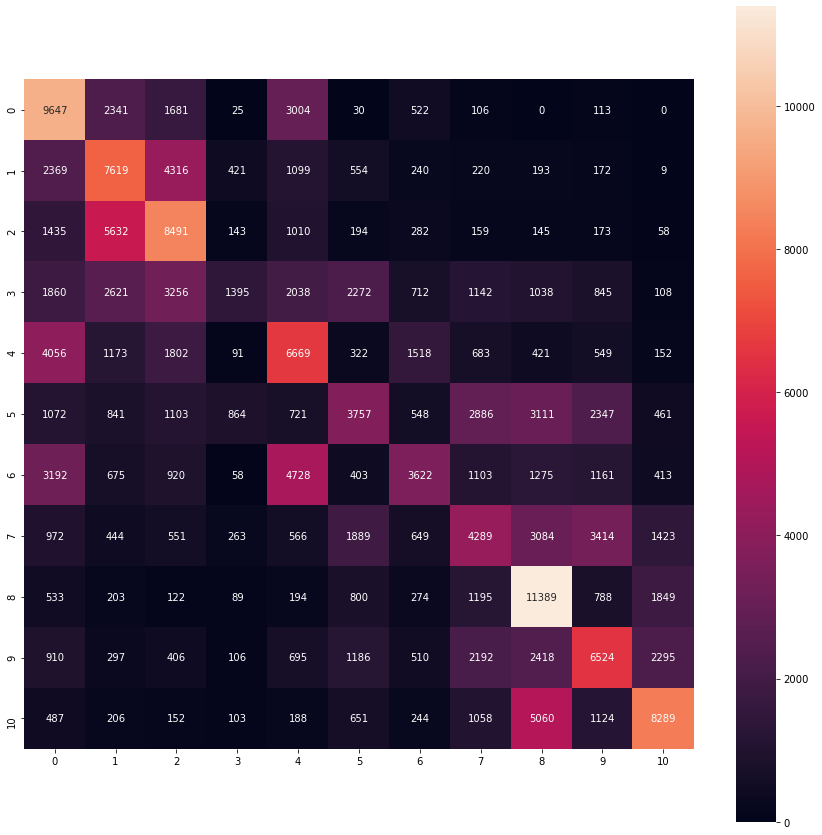

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


matrix = confusion_matrix(y_true, y_pred)
print(matrix)

plt.figure(figsize=(15,15))
sns.heatmap(matrix,annot=True, square = True, fmt='g')
plt.savefig("/home/jpozoc/barracuda/jpozoc/Ingenieria_Biomedica/4_INGENIERÍA_BIOMEDICA/2_CUATRIMESTRE/PMD/Notebooks/correlacion_confusion_pyspark.jpg")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
rfPred = cvModel.transform(df)
rfResult = rfPred.toPandas()
plt.plot(rfResult.label, rfResult.prediction, 'bo')
plt.xlabel('Price')
plt.ylabel('Prediction')
plt.suptitle("Model Performance accuracy: %f" % accuracy)
plt.show()